In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense
from pandas_profiling import ProfileReport


In [217]:
df = pd.read_csv('/Users/dponnappan/Downloads/sales_0_0_0.csv').fillna(0)
#print(df.head(10))
print("Max Date" ,df['DATE'].max(),"Min Date", df["DATE"].min())
#Going to do a grouping and see the results by date and location
print(df.groupby(['DATE','LOCATIONID','SKUID'])['UNITSSOLD'].sum())
#df = df[(df['UNITSSOLD']>0) & (df['AVAILABLEQUANTITY']>0)]
df_having_demand = df[(df['UNITSSOLD']>0)]
#Convert DATE to datetime
df_having_demand['DATE'] = pd.to_datetime(df_having_demand['DATE'])
print("Count of eligible rows (unitsold > 1",df_having_demand.count())
print(df_having_demand['DATE'].unique())
from sklearn.model_selection import train_test_split
X = df_having_demand.drop(['UNITSSOLD','DATE','PRODUCTID'],axis=1).values
y = df_having_demand['UNITSSOLD'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Shape of X (features)",X.shape," Y Outcomes ",y.shape)
from sklearn.utils import shuffle
# THe reason to shuffle is to introduce randomness to Train data
X_train, y_train = shuffle(X_train, y_train, random_state=13)


Max Date 2021-03-31 Min Date 2020-10-21
DATE        LOCATIONID  SKUID    
2020-10-21  610         3371671      0.0
                        3371672      0.0
                        3371673      0.0
                        3371677      0.0
                        3371678      0.0
                                    ... 
2021-03-31  12076       123177169    0.0
                        123177182    0.0
                        123950058    0.0
                        124400043    0.0
                        124400049    0.0
Name: UNITSSOLD, Length: 44212225, dtype: float64
Count of eligible rows (unitsold > 1 DATE                 161539
LOCATIONID           161539
SKUID                161539
PRODUCTID            161539
AVAILABLEQUANTITY    161539
UNITSSOLD            161539
UNITSRESTOCKED       161539
CURRENTPRICE         161539
LISTPRICE            161539
SALEPRICE            161539
dtype: int64
['2020-11-27T00:00:00.000000000' '2021-02-23T00:00:00.000000000'
 '2021-03-05T00:00:00.00000000

In [207]:
#EDA - Lets see common elements of our dataset
def eda(dataframe):
    print('Missing Values: {}'.format(dataframe.isnull().sum()))
    print('dataframe Index: {}'.format(dataframe.index))
    print('dataframe Types: {}'.format(dataframe.dtypes))
    print('dataframe Shape: {}'.format(dataframe.shape))
    print('dataframe describe: {}'.format(dataframe.describe()))
    for item in dataframe:
        print(item)
        print(dataframe[item].nunique())


In [208]:
def plot_missing_data_per_col(dataframe):
    dataframe.isnull().sum().plot(kind='bar')
    plt.title("Number of missing values per Column")
    plt.xticks(rotation=45)
    plt.xlabel("Columns")
    plt.ylabel("NaN Values")


Going to print eda for All items
Missing Values: DATE                 0
LOCATIONID           0
SKUID                0
PRODUCTID            0
AVAILABLEQUANTITY    0
UNITSSOLD            0
UNITSRESTOCKED       0
CURRENTPRICE         0
LISTPRICE            0
SALEPRICE            0
dtype: int64
dataframe Index: RangeIndex(start=0, stop=44212225, step=1)
dataframe Types: DATE                  object
LOCATIONID             int64
SKUID                  int64
PRODUCTID             object
AVAILABLEQUANTITY      int64
UNITSSOLD            float64
UNITSRESTOCKED         int64
CURRENTPRICE           int64
LISTPRICE              int64
SALEPRICE            float64
dtype: object
dataframe Shape: (44212225, 10)
dataframe describe:          LOCATIONID         SKUID  AVAILABLEQUANTITY     UNITSSOLD  \
count  4.421222e+07  4.421222e+07       4.421222e+07  4.421222e+07   
mean   2.180807e+04  1.027441e+08       2.131558e-01  4.348707e-03   
std    1.916941e+04  3.383656e+07       1.639859e+00  9.123389e-0

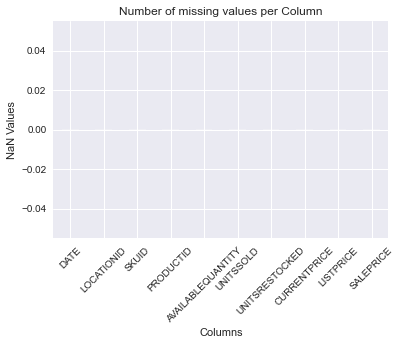

In [209]:
#Do an EDA and plot basic NaN Graphs
print("Going to print eda for All items")
eda(df)
plot_missing_data_per_col(df)
print("Going to print eda for products having atleast 1 unitssold")
eda(df_having_demand)
plot_missing_data_per_col(df_having_demand)
#As EDA shows no missing values we can safely start our test train split

In [159]:
#Lets do a simple autoviz EDA here
def autoviz_eda(dataframe):
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    dft = AV.AutoViz(filename='',sep=',',depVar='UNITSSOLD',\
                     dfte=dataframe,header=0,verbose=2,\
                     lowess=False,chart_format='SVG',\
                     max_rows_analyzed=100000,max_cols_analyzed=10)

In [160]:
#Lets do an Autoviz EDA of Dataframe
#autoviz_eda(df)

In [162]:
def pandas_profiling(dataframe,isMinimal=False):
    profile = ProfileReport(dataframe)
    profile.to_widgets()


In [163]:
pandas_profiling(df_having_demand)
print('Based on the EDA we can clearly see that the correlation of unitssold to saleprice and skuID to SalePrice has some correlation')

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Based on the EDA we can clearly see that the correlation of unitssold to saleprice and skuID to SalePrice has some correlation


In [164]:
'''
The Motivation for BayesianRidge comes from the fact that, Location and SKU combination is a class which can influence UNITSSOLD
BayesianRidge takes into account Categorical variables and builds Priors and Probabilities specific to those
'''
def predict_BayesianRidge():
    #%% We should get the X (Features) and Y (outcome) - Y is UNITSSOLD
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    bayesian_model = linear_model.BayesianRidge()
    linear_regression_model = linear_model.LinearRegression()
    bayesian_model.fit(X_train,y_train)
    y_predict = bayesian_model.predict(X_test)
    linear_regression_model.fit(X_train,y_train)
    y_predict_linear = linear_regression_model.predict(X_test)
    print("Going to publish the Prediction Results: BayesianRidge")
    print("Mean Squared Error: %2f"%mean_squared_error(y_test,y_predict))
    print("Coefficient of Prediction R2 Score (Closer to 1 is accurate) : %2f"%r2_score(y_test,y_predict))
    print("Going to publish the Prediction Results: Linear Regression")
    print("Mean Squared Error: %2f"%mean_squared_error(y_test,y_predict_linear))
    print("Coefficient of Prediction R2 Score (Closer to 1 is accurate) : %2f"%r2_score(y_test,y_predict_linear))
    #Plotting outputs
    xTestDF =pd.DataFrame(data=X_test,columns=["LOCATIONID","SKUID","AVAILABLEQUANTITY","UNITSRESTOCKED","CURRENTPRICE","LISTPRICE","SALEPRICE"])
    yTestDF = pd.DataFrame(data=y_test,columns=["UNITSSOLD_ACTUAL"])
    yPredictDF = pd.DataFrame(data=y_test,columns=["UNITSSOLD_PREDICTED"])
    plt.scatter(xTestDF["SKUID"],yTestDF["UNITSSOLD_ACTUAL"],color='black')
    plt.plot(yTestDF["UNITSSOLD_ACTUAL"],yPredictDF["UNITSSOLD_PREDICTED"],color='blue',linewidth=3)
    plt.xticks(())
    plt.yticks(())
    plt.show()

Going to publish the Prediction Results: BayesianRidge
Mean Squared Error: 0.739093
Coefficient of Prediction R2 Score (Closer to 1 is accurate) : 0.028645
Going to publish the Prediction Results: Linear Regression
Mean Squared Error: 0.739085
Coefficient of Prediction R2 Score (Closer to 1 is accurate) : 0.028656


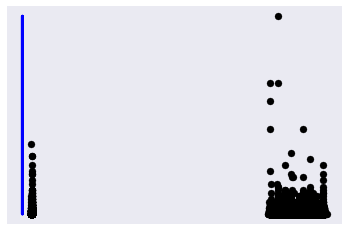

In [165]:
predict_BayesianRidge()


In [256]:
def predict_Kats():
    from kats.consts import  TimeSeriesData
    from kats.models.prophet import ProphetModel,ProphetParams,Prophet



    print(df_having_demand.head())
    demand_predictor_df = df_having_demand.drop(['PRODUCTID','AVAILABLEQUANTITY','UNITSRESTOCKED','CURRENTPRICE'],axis=1)
    demand_predictor_df = demand_predictor_df.rename(columns={"DATE":"time","UNITSSOLD":"Value"})

    print(demand_predictor_df.dtypes)
    print(demand_predictor_df.head())
    demand_predictor_ts = TimeSeriesData(time=demand_predictor_df.time,date_format='YYYY-MM-dd',value=demand_predictor_df.Value)
    params = ProphetParams(seasonality_mode='multiplicative')
    model = ProphetModel(demand_predictor_ts,params)
    prophet_X = demand_predictor_df.drop(['Value'],axis=1)
    prophet_y = demand_predictor_df['Value']
    X_pro_train, X_pro_test, y_pro_train, y_pro_test = train_test_split(prophet_X, prophet_y, test_size=0.25, random_state=42)
    print("Shape of X (features)",prophet_X.shape," Y Outcomes ",prophet_y.shape)
    from sklearn.utils import shuffle
    # THe reason to shuffle is to introduce randomness to Train data
    X_pro_train, y_pro_train = shuffle(X_pro_train, y_pro_train, random_state=13)
    train_dataset = pd.DataFrame()
    train_dataset['ds'] = X_pro_train["time"]
    train_dataset['LOCATIONID'] = X_pro_train["LOCATIONID"]
    train_dataset['SKUID'] = X_pro_train["SKUID"]
    train_dataset['SALEPRICE'] = X_pro_train["SALEPRICE"]
    train_dataset['LISTPRICE'] = X_pro_train["LISTPRICE"]
    train_dataset['y']  = y_pro_train
#Now we are defining Test Data set
    test_dataset = pd.DataFrame()
    test_dataset['ds'] = X_pro_test["time"]
    test_dataset['LOCATIONID'] = X_pro_test["LOCATIONID"]
    test_dataset['SKUID'] = X_pro_test["SKUID"]
    test_dataset['SALEPRICE'] = X_pro_test["SALEPRICE"]
    test_dataset['LISTPRICE'] = X_pro_test["LISTPRICE"]
    test_dataset['y']  = y_pro_test

    train_dataset.head(2)
    m = Prophet()
    #m.add_regressor("LOCATIONID")
    #m.add_regressor("SKUID")
    #m.add_regressor("SALEPRICE")
    m.fit(train_dataset)
    future = m.make_future_dataframe(periods=500)
    forecast = m.predict(test_dataset)
    forecast.plot()
    m.plot(forecast)
    fig1 = m.plot_components(forecast)
    print("Going to Predict with additional regressors")
    m = Prophet()
    m.add_regressor("LOCATIONID")
    m.add_regressor("SKUID")
    m.add_regressor("SALEPRICE")
    m.add_regressor("LISTPRICE")
    m.fit(train_dataset)
    future = m.make_future_dataframe(periods=500)
    forecast = m.predict(test_dataset)
    forecast.plot()
    m.plot(forecast)
    fig1 = m.plot_components(forecast)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


              DATE  LOCATIONID      SKUID    PRODUCTID  AVAILABLEQUANTITY  \
2302600 2020-11-27       10110  113226096  prod8960003                  0   
2302703 2020-11-27       10110    3763546  prod8601718                 21   
2302846 2020-11-27       10110  118925417  prod9960764                  1   
2302884 2020-11-27       10110  114751592  prod9920165                  0   
2302976 2020-11-27       10110  104455678  prod4850104                  0   

         UNITSSOLD  UNITSRESTOCKED  CURRENTPRICE  LISTPRICE  SALEPRICE  
2302600        1.0               0           128        128        0.0  
2302703        2.0               0            12         12        0.0  
2302846        1.0               0           168        168        0.0  
2302884        1.0               0            39         68       39.0  
2302976        1.0               0            88         88        0.0  
time          datetime64[ns]
LOCATIONID             int64
SKUID                  int64
Value       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Going to Predict with additional regressors


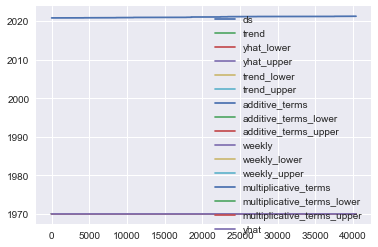

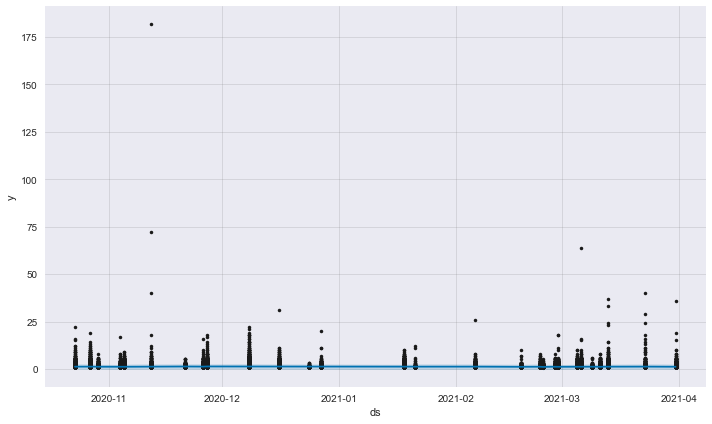

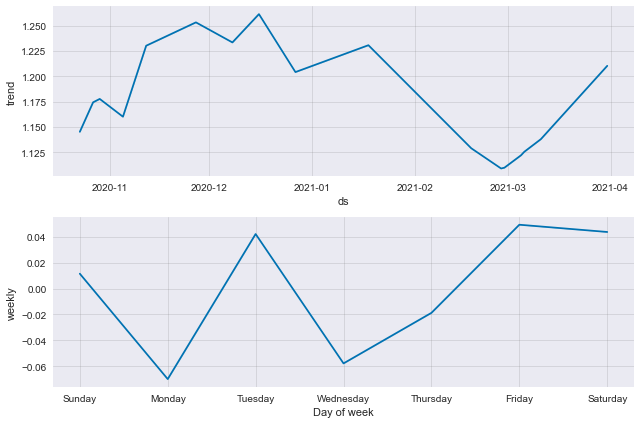

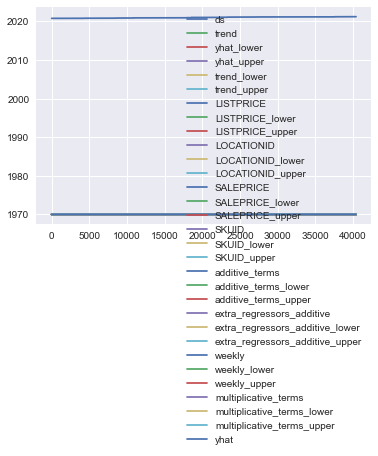

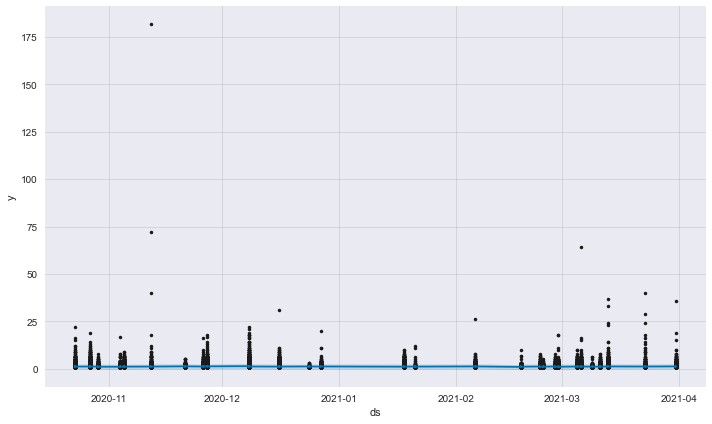

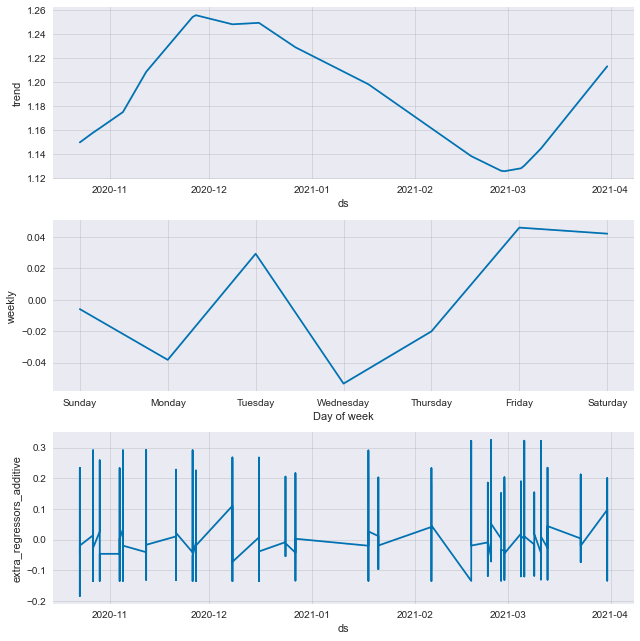

In [257]:
predict_Kats()
